<a href="https://colab.research.google.com/github/thewelzin/yana/blob/main/YANA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YANA - Yet Another News Agrregator

/bin/bash: line 1: nvidia-smi: command not found
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13269    0 13269    0     0  61411      0 --:--:-- --:--:-- --:--:-- 61716
>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive

Reading news sites: 0it [00:00, ?it/s]

Website No: 0, Url: https://www.indiatoday.in/
paper size:  12


Pulling Articles:   0%|          | 0/12 [00:00<?, ?it/s]

Error parsing article https://specials.indiatoday.com/business/story/amazon-india-hit-with-39-million-penalty-for-apparel-trademark-violation-2686565-2025-02-27#?utm_source=Story_hp&utm_medium=Story&utm_campaign=home_Story: Article `download()` failed with 404 Client Error: Not Found for url: https://specials.indiatoday.com/business/story/amazon-india-hit-with-39-million-penalty-for-apparel-trademark-violation-2686565-2025-02-27#?utm_source=Story_hp&utm_medium=Story&utm_campaign=home_Story on URL https://specials.indiatoday.com/business/story/amazon-india-hit-with-39-million-penalty-for-apparel-trademark-violation-2686565-2025-02-27#?utm_source=Story_hp&utm_medium=Story&utm_campaign=home_Story
Error parsing article https://specials.indiatoday.com/india/story/prayagraj-flights-business-jets-number-maha-kumbh-2686580-2025-02-27: Article `download()` failed with 404 Client Error: Not Found for url: https://specials.indiatoday.com/india/story/prayagraj-flights-business-jets-number-maha-kum

Generating LLM headlines and news for today:   0%|          | 0/6 [00:00<?, ?it/s]

0    Why are southern states wary of delimitation? ...
Name: title, dtype: object
0    With Tamil Nadu Chief Minister MK Stalin reope...
Name: summary, dtype: object
Running LLM for similarity search (this may take a while to complete): Article 0
--- 0 
llm_headline:  Tech Company’s Revenue Breaks Record: Wordy Stands Out 
llm_news:  Tech Company's revenue reached a record-breaking $250 million, solidifying their position as a leader in their field. Multiple reports highlighted their success and praised other experts for their positive outlook.
================== STEP 4: Generating insta posts ==================


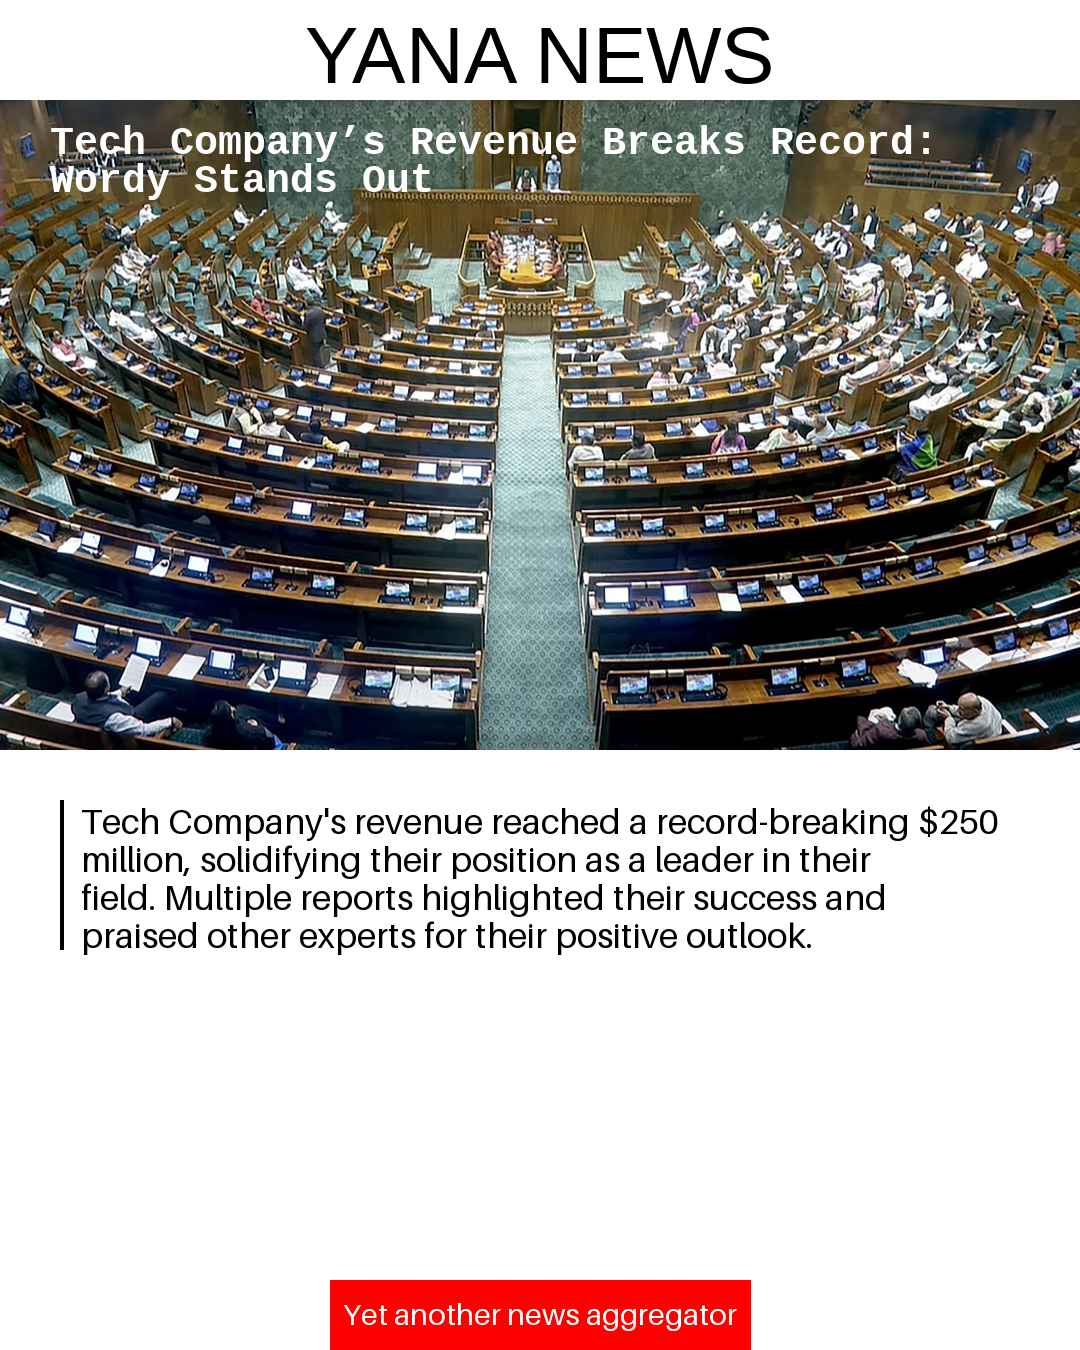

1    Samsung Galaxy S25+ review: Plus matters
Name: title, dtype: object
1    advertisementSamsung Galaxy S25 Plus price in ...
Name: summary, dtype: object
Running LLM for similarity search (this may take a while to complete): Article 1
--- 1 
llm_headline:   
llm_news:  
================== STEP 4: Generating insta posts ==================


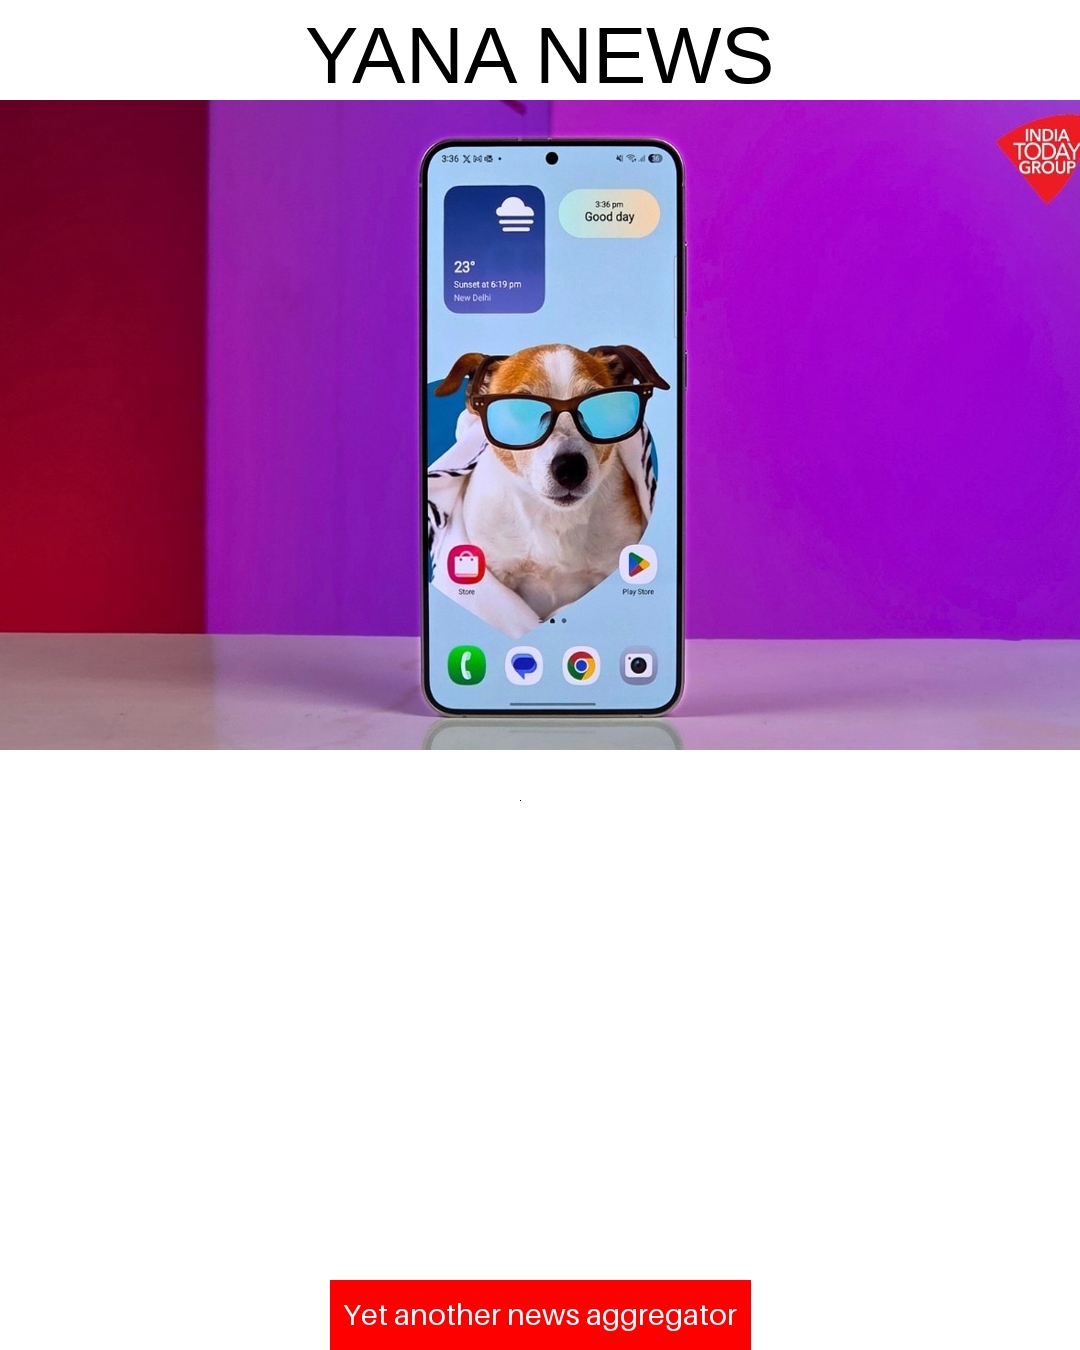

2    No Class 10 certificate without Punjabi? Punja...
Name: title, dtype: object
2    The controversy arose after the CBSE draft sch...
Name: summary, dtype: object
Running LLM for similarity search (this may take a while to complete): Article 2
--- 2 
llm_headline:  Breakaway News in Story_hp: New Developments Revealed in Home Story 
llm_news:  Breakaway News in Story_hp: New Developments Revealed in Home Story
================== STEP 4: Generating insta posts ==================


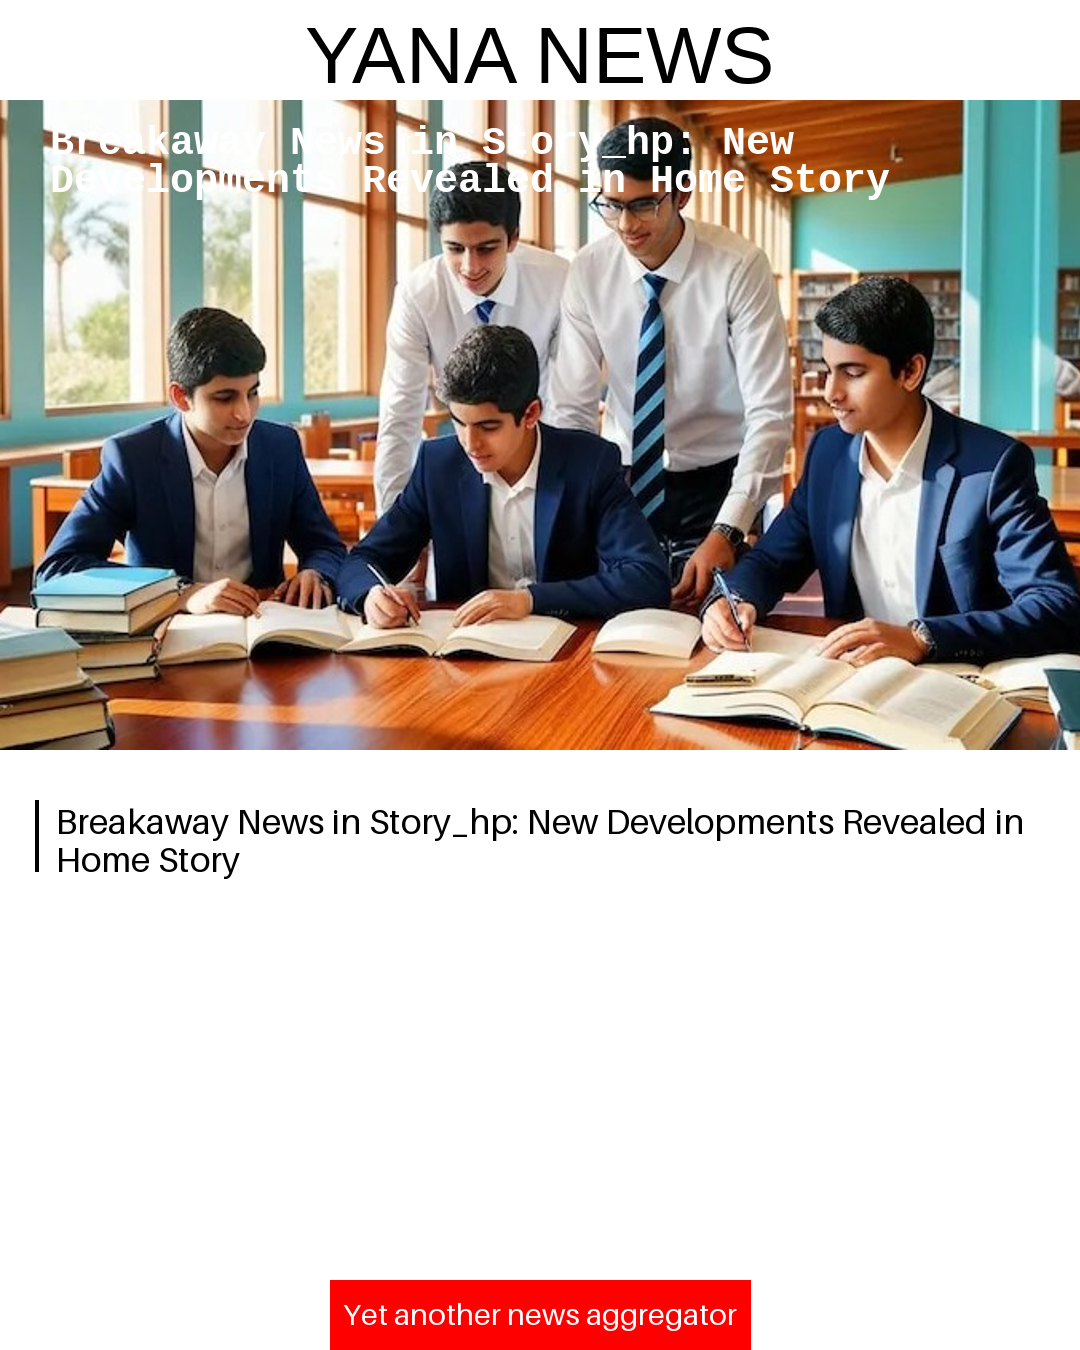

3    Why Nitish Kumar's all-BJP cabinet induction s...
Name: title, dtype: object
3    advertisementWith the additions, the cabinet h...
Name: summary, dtype: object
Running LLM for similarity search (this may take a while to complete): Article 3


In [ ]:
# Install modules
!pip install -q -U langchain langchain-community chromadb gradio pymupdf python-docx ollama langchain-huggingface newspaper3k lxml-html-clean pillow

# Install Ollama and CUDA drivers
import os
!nvidia-smi
!curl https://ollama.ai/install.sh | sh
!echo 'debconf debconf/frontend select Noninteractive' | sudo debconf-set-selections
!sudo apt-get update && sudo apt-get install -y cuda-drivers
# Set LD_LIBRARY_PATH so the system NVIDIA library
os.environ.update({'LD_LIBRARY_PATH': '/usr/lib64-nvidia'})

!nohup ollama serve &
!ollama ps
!ollama pull deepseek-r1:1.5b
!ollama list

from datetime import datetime
import pandas as pd
from tqdm.notebook import tqdm
import json
import re
import urllib
import pprint
from IPython import embed
import matplotlib.font_manager
import matplotlib as mpl
import newspaper
from newspaper import Config
import sqlite3
import codecs
import base64
import PIL
from PIL import Image, ImageFont, ImageDraw
import textwrap
from IPython.display import Image, display

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from transformers import pipeline

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain_community.llms import Ollama

from google.colab import drive
import warnings
warnings.filterwarnings('ignore')


# Download necessary NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)
nltk.download('punkt_tab', quiet=True)
stop_words = set(nltk.corpus.stopwords.words('english'))

# Configuration
config = Config()
config.request_timeout = 10 # Increase timeout to 15 seconds (or more)

CURRENT_DATE = datetime.now().date()
BASE_PATH = '/content/YANA'
DB_PATH = '/content/drive/MyDrive/YanaNewsProd.db'
ENV = 'prod'
URL_LIST = ['https://www.indiatoday.in/']
EMBEDDING_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
DEEPSEEK_MODEL = 'deepseek-r1:1.5b' #['deepseek-r1:1.5b', 'deepseek-r1:7b', 'deepseek-r1:14b']

# Directory Setup (once)
drive.mount('/content/drive')

DIRECTORIES = {
    'insta_posts': os.path.join(BASE_PATH, ENV, 'images', 'insta_posts', str(CURRENT_DATE))
}

for path in DIRECTORIES.values():
    os.makedirs(path, exist_ok=True)
    print(f"Directory created: {path}")

# Load sqlite3 db from google drive
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
for table in tables:
  print(f"- {table[0]}")

# Get the table size in bytes
cursor.execute(f"SELECT page_count * page_size FROM pragma_page_count(), pragma_page_size()")
size_bytes = cursor.fetchone()[0]
size_mb = size_bytes / (1024 * 1024)  # Convert bytes to MB
print(f"  Approximate Size: {size_mb:.2f} MB")
conn.execute("VACUUM")
conn.commit()
# cursor.execute("drop table final_news;").fetchall()
# conn.commit()

def news_puller():
  print('================== STEP 1: Pulling from news sites ==================')
  for index, link in tqdm(enumerate(URL_LIST), desc='Reading news sites'):
      print(f"Website No: {index}, Url: {link}")
      news = []
      paper = newspaper.build(link,
                              language='en',
                              memoize_articles=True,
                              fetch_images=True,
                              threads=2,
                              config=config)
      print('paper size: ', paper.size())

      # for category_urls in tqdm(paper.category_urls(), desc="Scraping News Categories"):
      #     print('category_urls: ' + category_urls)
      #     url = newspaper.build(category_urls,
      #                           language='en',
      #                           memoize_articles=True,
      #                           fetch_images=True,
      #                           threads=2,
      #                           config=config)

      article_count = 0
      for article in tqdm(paper.articles, desc="Pulling Articles"):
          try:
            article.download()
            article.parse()
            article.nlp()

            if article.text and article.top_image:  # Check if article.text is not empty
              try:
                  # Fetch the image directly
                  with urllib.request.urlopen(article.top_image) as response:
                    blob_data = response.read()
                    encoded_img = base64.b64encode(blob_data).decode('utf-8')

                    # Append as a list to ensure correct column mapping
                    news.append([link, article.url, article.title, article.publish_date, article.summary, str(article.keywords), article.text, encoded_img])

                    # Create the DataFrame and assign column names here
                    source_news = pd.DataFrame(news, columns=["source", "link", "title", "publish_date", "summary", "keywords", "desc", "img"])
                    source_news.to_sql('raw_news', conn, if_exists='append', index=False)
                    conn.commit()
                    article_count+=1

              except Exception as e:
                  print(f"Error processing image from {article.top_image}: {e}")

            if article_count>=10:  # Stop after 10 articles
                break

          except Exception as e:
            print(f"Error parsing article {article.url}: {e}")
            continue
  # Dedup raw_news table
  cursor.execute("DELETE FROM raw_news where rowid not in (SELECT min(rowid) FROM raw_news GROUP BY title)").fetchall()
  conn.commit()


def news_cleaner():
  print('================== Step 2: Clean the news - drop dups, filter ==================')
  raw_news = cursor.execute("SELECT distinct * FROM raw_news").fetchall()
  raw_news = pd.DataFrame(raw_news, columns=[description[0] for description in cursor.description])
  print('raw_news: ', raw_news.shape)

  raw_news = raw_news.drop_duplicates(subset=['title'], keep='first').dropna()
  raw_news['dt'] = raw_news['publish_date'].str.slice(0, 10)
  raw_news.drop(columns='publish_date', inplace=True)
  raw_news.rename(columns={'dt': 'publish_date'}, inplace=True)

  raw_news = raw_news[["source", "link", "title", "publish_date", "summary", "keywords", "desc", "img"]]
  raw_news['publish_date'] = raw_news['publish_date'].fillna(str(CURRENT_DATE))
  raw_news['publish_date'] = raw_news['publish_date'].replace('None', str(CURRENT_DATE))

  raw_news['summary'] = raw_news['summary'].str.strip()
  raw_news['title'] = raw_news['title'].str.strip()

  clean_news = raw_news.reset_index(drop=True)
  clean_news.to_sql('clean_news', conn, if_exists='append', index=False)
  conn.commit()
  # Dedup clean_news table
  cursor.execute("DELETE FROM clean_news where rowid not in (SELECT min(rowid) FROM clean_news GROUP BY title)").fetchall()
  conn.commit()


# Method to generate news post images for social media
def generate_insta_image(current_df):
  print('================== STEP 4: Generating insta posts ==================')
  # Installing Lobster font
  !wget -q https://github.com/google/fonts/raw/main/ofl/lobster/Lobster-Regular.ttf -O /usr/local/share/fonts/Lobster-Regular.ttf
  mpl.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
  custom_font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', 80)  # Adjust size as needed

  # Default Font Sizes
  FONT_SIZES = {
      "title": 45,
      "date": 22,
      "metadata": 22,
      "header": 75,
      "footer": 30,
      "summary": 35
  }

  for index, row in current_df.iterrows():
      try:
          insta_image = PIL.Image.new("RGB", (1080, 1350), color="white")
          x, y = insta_image.size
          draw = ImageDraw.Draw(insta_image)

          # Load Default Fonts (no paths specified)
          fonts = {}
          for name, size in FONT_SIZES.items():
              fonts[name] = ImageFont.load_default(size)

          # Create Header
          header_text = 'YANA NEWS'
          bbox_header = draw.textbbox((0, 0), header_text, font=custom_font)
          textwidth_header = bbox_header[2] - bbox_header[0]
          draw.text((x / 2 - textwidth_header / 2, 10), header_text, fill='Black', font=custom_font)

          # Create article image from the decoded data
          import io
          decoded_image_data = base64.b64decode(row['img'])
          article_image = PIL.Image.open(io.BytesIO(decoded_image_data))
          article_image = article_image.resize((1100, 650))
          insta_image.paste(article_image, (0, 100))

          # Create title
          title = textwrap.fill(text=str(current_df["llm_headline"][index]), width=40)
          # Calculate text bounding box
          bbox_title = draw.textbbox((0, 0), title, font=fonts["title"])
          textwidth_title = bbox_title[2] - bbox_title[0]
          textheight_title = bbox_title[3] - bbox_title[1]

          bbox_title = draw.textbbox((0, 0), title, font=fonts["title"])
          textwidth_title = bbox_title[2] - bbox_title[0]
          fonts["title"] = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', 40)

          draw.text((50, 120), title, fill='white', font=fonts["title"])

          # Create Summary
          summary = textwrap.fill(text=str(current_df['llm_news'][index]), width=57)
          bbox_summary = draw.textbbox((0, 0), summary, font=fonts["summary"])
          textwidth_summary = bbox_summary[2] - bbox_summary[0]

          # Calculate coordinates for vertical line
          line_x = (x / 2 - textwidth_summary / 2) - 20  # Adjust spacing as needed
          line_y1 = 800  # Start of the line (align with summary)
          line_y2 = line_y1 + bbox_summary[3] - bbox_summary[1]  # End of the line (summary height)

          # Draw vertical line
          draw.line([(line_x, line_y1), (line_x, line_y2)], fill='black', width=4)
          # Draw the summary text
          draw.text((x / 2 - textwidth_summary / 2, 800), summary, fill='black', font=fonts["summary"])

          # Footer
          draw.rectangle((330, 1280, 750, 1380), fill='red', width=5)
          yana = 'Yet another news aggregator'
          bbox_yana = draw.textbbox((0, 0), yana, font=fonts["footer"])
          textwidth_yana = bbox_yana[2] - bbox_yana[0]
          draw.text((x / 2 - textwidth_yana / 2, 1295), yana, fill='white', font=fonts["footer"])

          # write post images to a directory
          insta_image.save(f"/content/YANA/{ENV}/images/insta_posts/{CURRENT_DATE}/post_{CURRENT_DATE}_{index}.jpg")
          display(insta_image)

      except KeyError as e:
          print(f"Error: DataFrame column not found: {e}")
      except Exception as e:
          print(f"An unexpected error occurred: {e}")


def rag_pipeline():
  print('================== STEP 3: Running RAG to generate news ==================')
  # Use deepseek RAG pipeline to generate news headline and news article
  # 1. Load clean news data from SQLite DB
  clean_news = cursor.execute(f"SELECT distinct * FROM clean_news where publish_date='2025-02-27' ;").fetchall()
  clean_news = pd.DataFrame(clean_news, columns=[description[0] for description in cursor.description])
  print('Number of News Articles for RAG: ', clean_news.shape)

  for i in tqdm(range(len(clean_news)), desc='Generating LLM headlines and news for today'):
    current_df = clean_news.iloc[[i]]
    article_content = []
    for column in current_df.columns:
        article_content.append(f"\n## {column}\n{current_df[column].values[0]}\n")
    article = "".join(article_content)
    documents = [article]

    # 2. Split documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=50)
    texts = text_splitter.create_documents(documents)

    # 3. Create embeddings
    embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)

    # 4. Store in vector database
    existing_collection = Chroma(persist_directory="./chroma_db")
    existing_collection.delete_collection()
    db = Chroma.from_documents(texts, embeddings, persist_directory="./chroma_db")

    # 5. Initialize LLM and RetrievalQA chain
    llm = Ollama(model=DEEPSEEK_MODEL)
    retriever = db.as_retriever()
    qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever)

    # 6. Ask a question
    query = """
            ## CONTEXT:
              You are a news editor skilled at writing attention-grabbing headlines and news.
              Your task is to create compelling and catchy headlines and news summaries based on the data given.
              Your task is to rewrite the given text for better flow and comprehension.
            ## GOAL:
              Generate a compelling and SEO-friendly headline and a news summary that drive clicks and reader interest.
              Make sure that the factual information is correct.
              The output MUST be in the given json format.
              The generated llm_headline should be of EXACTLY 150 characters.
              The generated llm_news should be of EXACTLY 500 characters.

            ## RESPONSE GUIDELINES:
              Improve readability and structure.
              Keep the news crisp, clear and concise but detailed enough to spark creativity.
              Make the headline concise but intriguing.

            Output Format:
              json
              {
                  "llm_headline": "Your Headline Here", # 150 characters
                  "llm_news": "Your News Summary Here"  # 500 characters
              }
              """
    print(f'Running LLM for similarity search (this may take a while to complete): Article {i}')
    result = qa.run(query)

    # 7. Clean & Extract JSON Data
    result = re.sub(r"<think>.*?</think>", "", result, flags=re.DOTALL)

    # Find the JSON block using regex with capturing group
    json_match = re.search(r'(\{.*\})', result, re.DOTALL)

    llm_headline, llm_news = "", ""
    if json_match:
      json_string = json_match.group(1)  # Access the captured json group
      try:
        data = json.loads(json_string)
        # Assign values to DataFrame columns
        llm_headline = data.get("llm_headline", "")
        llm_news = data.get("llm_news", "")
        print('---', i, '\nTitle: ', current_df['title'], '\nllm_headline: ', llm_headline, '\nllm_news: ', llm_news)
      except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")

    current_df['llm_headline'] = data.get("llm_headline", "")
    current_df['llm_news'] = data.get("llm_news", "")
    current_df.to_sql('final_news', conn, if_exists='append', index=False)
    conn.commit()
    # Dedup final_news table
    cursor.execute("DELETE FROM final_news where rowid not in (SELECT min(rowid) FROM final_news GROUP BY title)").fetchall()
    conn.commit()
    generate_insta_image(current_df)


def display_images():
  # Display each image
  for num in range(10):
      display(Image(filename=f'/content/YANA/{ENV}/images/insta_posts/{CURRENT_DATE}/post_{CURRENT_DATE}_{num}.jpg'))


# Run methods for each step
news_puller()
news_cleaner()
rag_pipeline()
#display_images()

In [ ]:
# Generate images directly from final table without deepseek run
final_news = cursor.execute(f"SELECT distinct * FROM final_news;").fetchall()
final_news = pd.DataFrame(final_news, columns=[description[0] for description in cursor.description])
generate_insta_image(final_news)